In [3]:
import os
import warnings

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from omegaconf import OmegaConf
from openai import OpenAI
from tqdm import tqdm
from transformers import logging as transformers_logging

# from lm_polygraph.estimators import MeanTokenEntropy, TokenSAR
# from lm_polygraph.utils.manager import estimate_uncertainty
# from lm_polygraph.utils.model import WhiteboxModel
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt
from dataset import (
    OurNQDataset,
    Squad2Dataset,
    NQDataset,
    TriviaQADataset, 
    SquadDataset, 
    WikiMultiHopQADataset, 
    HotPotQADataset, 
    MusiqueDataset
)

load_dotenv()
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()

## Datasets

In [4]:
nq_dataset = NQDataset().data
our_nq_dataset = OurNQDataset().data
squad2_dataset = Squad2Dataset().data
trivia_qa_dataset = TriviaQADataset().data
squad_dataset = SquadDataset().data
wiki_multi_dataset = WikiMultiHopQADataset().data
hot_pot_dataset = HotPotQADataset().data
musique_dataset = MusiqueDataset().data

In [3]:
cfg = OmegaConf.load("config.yaml")

model = WhiteboxModel.from_pretrained(
    model_path=cfg.model_id, 
    generation_params=cfg.generation_config,
    device_map="auto"
)

TokenSAR_method = TokenSAR()
MeanTokenEntropy_method = MeanTokenEntropy()

WhiteboxModel#from_pretrained is deprecated and will be removed in the next release. Please instantiate WhiteboxModel directly by passing an already loaded model, tokenizer and model path.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


## Some ue scores visualizations (nq_dataset)

In [51]:
nq_dataset = load_dataset('cjlovering/natural-questions-short')['train'].shuffle(seed=42).select(range(1000)).to_pandas()
nq_dataset = nq_dataset[['contexts', 'questions', 'answers']]
nq_dataset['questions'] = nq_dataset['questions'].apply(lambda x: x[0]['input_text'])
nq_dataset['answers'] = nq_dataset['answers'].apply(lambda x: x[0]['span_text'])
nq_dataset = nq_dataset.rename(columns={'questions': 'question', 'answers': 'golden_answer', 'contexts': 'context'})

In [ ]:
nq_dataset

In [ ]:
for index, row in tqdm(nq_dataset.iterrows()):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    # clean_entropy without context
    result = estimate_uncertainty(
        model,
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=True
    )
    answer_without_context, clean_entropy_without_context = result.generation_text, result.uncertainty

    # clean_entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=True
    )
    answer_with_context, clean_entropy_with_context = result.generation_text, result.uncertainty

    # token_sar without context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, token_sar_without_context = result.generation_text, result.uncertainty

    # token_sar with context
    result = estimate_uncertainty(
        model, 
        TokenSAR_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    answer_with_context, token_sar_with_context = result.generation_text, result.uncertainty

    nq_dataset.loc[index, f'our_answer_without_context'] = answer_without_context
    nq_dataset.loc[index, f'our_answer_with_context'] = answer_with_context

    nq_dataset.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    nq_dataset.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)
    nq_dataset.loc[index, 'clean_entropy_without_context'] = round(clean_entropy_without_context, 4)
    nq_dataset.loc[index, 'clean_entropy_with_context'] = round(clean_entropy_with_context, 4)
    nq_dataset.loc[index, 'token_sar_without_context'] = round(token_sar_without_context, 4)
    nq_dataset.loc[index, 'token_sar_with_context'] = round(token_sar_with_context, 4)
    
nq_dataset.to_csv('data/nq_dataset_with_generated_answers.csv', index=False)

16it [14:45, 47.57s/it]

## Add correctness of generated answer by gpt-4o

In [2]:
nq_dataset = pd.read_csv('data/nq_dataset_with_generated_answers.csv')

In [38]:
system_prompt = """You will be given a user query, a reference answer, and a model's response. Your task is to evaluate the model’s response only in relation to the reference answer. Focus on the accuracy and completeness of the information in the model’s response compared to the reference. Ignore stylistic differences or minor rephrasings

Evaluation criteria:

Score 0 if the model's answer is entirely incorrect or no answer is provided.
Score 0.5 if the model’s answer contains inaccuracies, lacks information, or includes extraneous details not relevant to the query.
Score 1 if the model’s answer is entirely correct and sufficiently answers the query without unnecessary information.
Provide your answer in the format: Score.

Your evaluation will be used to measure consistency and accuracy."""

user_prompt = """Please evaluate the model's response based on its accuracy compared to the reference answer, using one of the following scores:

0: Incorrect or no response
0.5: Partially correct (contains errors, lacks information, or is excessive)
1: Completely correct
Format: Score.

Question: {question} 
Reference Answer: {golden_answer} 
Model Answer: {model_answer}"""

In [ ]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

for index, row in tqdm(nq_dataset.iterrows()):
    question = row['question']
    answer_without_context = row['our_answer_without_context']
    answer_with_context = row["our_answer_with_context"]
    golden_answer = row['golden_answer']

    user_prompt_without_context = user_prompt.format(
        question=question, 
        golden_answer=golden_answer, 
        model_answer=answer_without_context
    )

    user_prompt_with_context = user_prompt.format(
        question=question, 
        golden_answer=golden_answer, 
        model_answer=answer_with_context
    )

    chatgpt_is_correct_without_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": user_prompt_without_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    chatgpt_is_correct_with_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": user_prompt_with_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    nq_dataset.loc[index, 'chatgpt_is_correct_without_context'] = chatgpt_is_correct_without_context
    nq_dataset.loc[index, 'chatgpt_is_correct_with_context'] = chatgpt_is_correct_with_context

In [46]:
nq_dataset.head()

,context,question,golden_answer,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context,clean_entropy_without_context,clean_entropy_with_context,token_sar_without_context,token_sar_with_context,cotype_is_correct_without_context,cotype_is_correct_with_context,chatgpt_is_correct_without_context,chatgpt_is_correct_with_context
0,The Truman Doctrine was an American foreign po...,what did the u.s. policy called the truman doc...,created to counter Soviet geopolitical expansi...,"The Truman Doctrine, announced by President Ha...",The Truman Doctrine promised to contain Soviet...,0.3936,0.4015,0.3973,0.3337,0.1740,0.1353,1.0,1.0,1.0,1.0
1,The Dark Tower Theatrical release poster Direc...,who wrote the screenplay for the dark tower,Akiva Goldsman Jeff Pinkner Anders Thomas Jens...,"The screenplay for the 2017 film ""The Dark Tow...","Akiva Goldsman, Jeff Pinkner, and Anders Thoma...",0.3243,0.3363,0.2376,0.2832,0.0623,0.1727,1.0,1.0,1.0,0.5
2,This article lists the fifty most - subscribed...,who has the most subscribers in you tube,PewDiePie,As of my cut-off knowledge date (December 2023...,PewDiePie,0.2451,0.1948,0.2715,0.1948,0.1315,0.0115,0.5,1.0,0.5,1.0
3,The San Luis Valley is a region in south - cen...,where is the san luis valley in colorado,south - central Colorado with a small portion ...,The San Luis Valley is located in southern Col...,The San Luis Valley is located in south-centra...,0.3940,0.2693,0.4626,0.1976,0.3080,0.1183,1.0,1.0,0.5,1.0
4,"Gastric acid , gastric juice or stomach acid ,...",what is the acid in the stomach called,"Gastric acid , gastric juice or stomach acid",The acid in the stomach is hydrochloric acid (...,Hydrochloric acid (HCl),0.3071,0.3508,0.2483,0.2741,0.1856,0.1963,1.0,1.0,0.5,0.5


In [3]:
color_map = {1: 'green', 0.5: 'yellow', 0: 'red'}
colors_with_context = nq_dataset['chatgpt_is_correct_with_context'].map(color_map)
colors_without_context = nq_dataset['chatgpt_is_correct_without_context'].map(color_map)

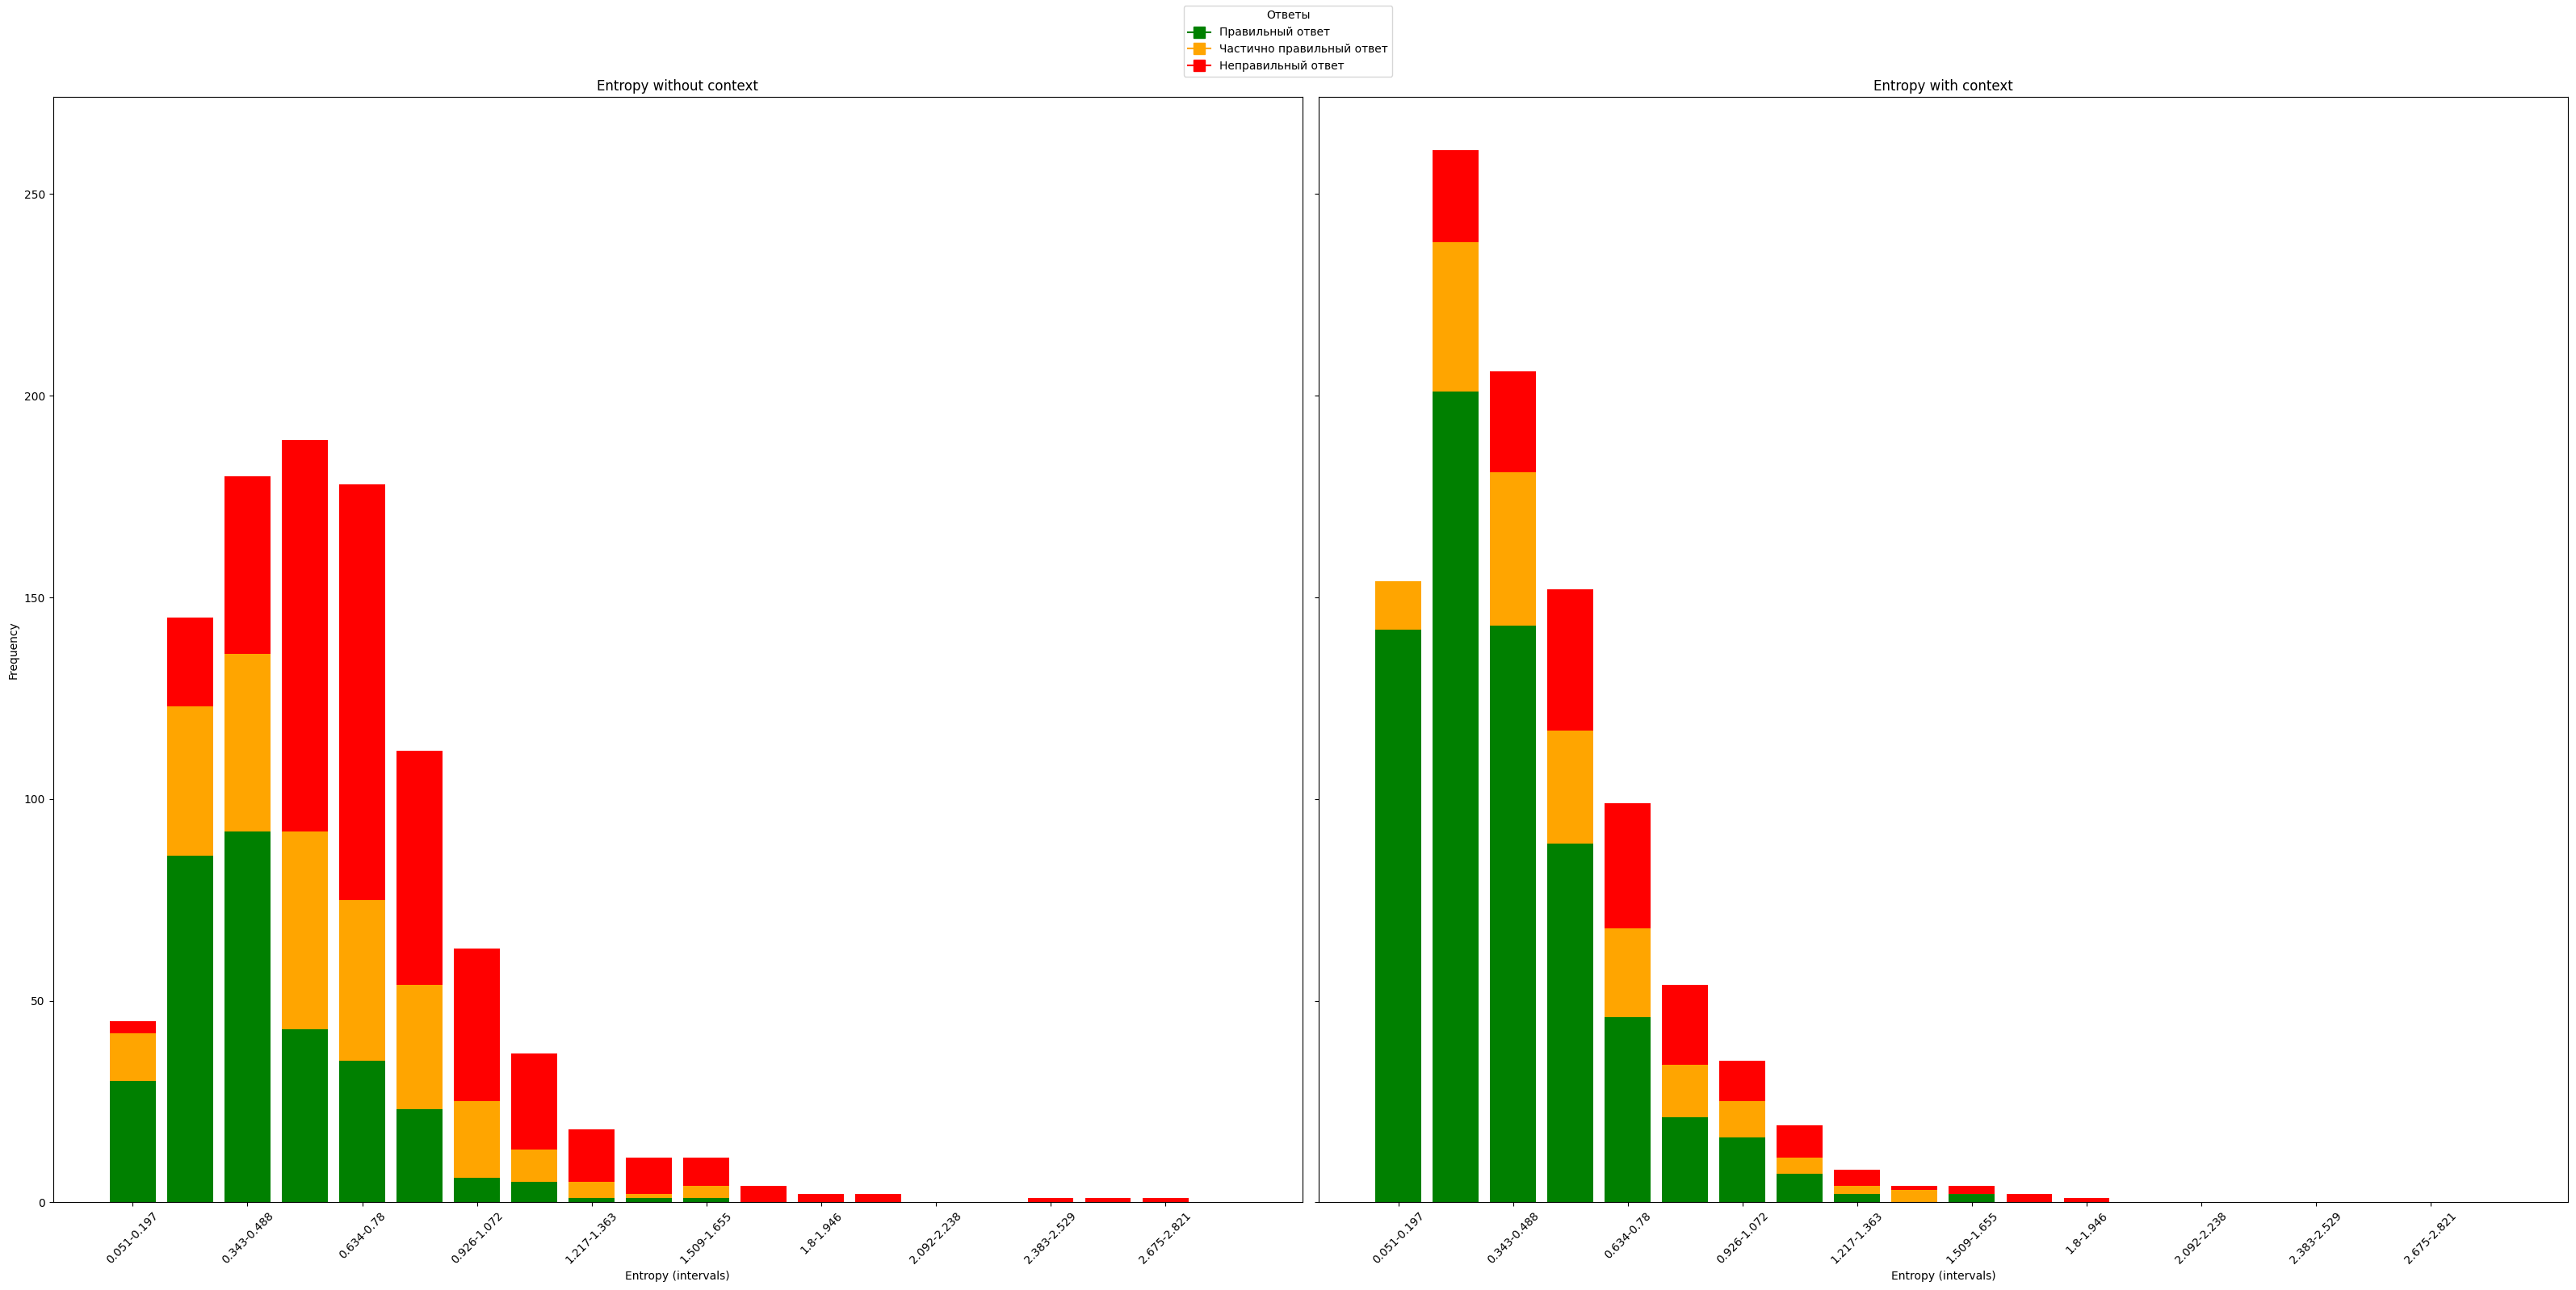

In [20]:
entropy_min = min(nq_dataset['entropy_without_context'].min(), nq_dataset['entropy_with_context'].min())
entropy_max = max(nq_dataset['entropy_without_context'].max(), nq_dataset['entropy_with_context'].max())
bin_edges = np.linspace(entropy_min, entropy_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'correct': 0,
    'partially_correct': 0,
    'incorrect': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask = (nq_dataset['entropy_without_context'] >= bin_edges[i]) & (nq_dataset['entropy_without_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 1).values)
    binned_data_without_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0.5).values)
    binned_data_without_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0).values)

for i in range(num_bins):
    bin_mask = (nq_dataset['entropy_with_context'] >= bin_edges[i]) & (nq_dataset['entropy_with_context'] < bin_edges[i + 1])
    binned_data_with_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 1).values)
    binned_data_with_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0.5).values)
    binned_data_with_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0).values)

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['correct'], color='green', label='Правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['partially_correct'], bottom=binned_data_without_context['correct'], color='orange', label='Частично правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['incorrect'], bottom=binned_data_without_context['correct'] + binned_data_without_context['partially_correct'], color='red', label='Неправильный ответ')
ax1.set_xlabel('Entropy (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Entropy without context')
ax1.set_xticks(np.arange(0, len(x_labels_without_context), max(1, len(x_labels_without_context) // 10)))
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['correct'], color='green', label='Правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['partially_correct'], bottom=binned_data_with_context['correct'], color='orange', label='Частично правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['incorrect'], bottom=binned_data_with_context['correct'] + binned_data_with_context['partially_correct'], color='red', label='Неправильный ответ')
ax2.set_xlabel('Entropy (intervals)')
ax2.set_title('Entropy with context')
ax2.set_xticks(np.arange(0, len(x_labels_with_context), max(1, len(x_labels_with_context) // 10)))
ax2.tick_params(axis='x', rotation=45)

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [
    plt.Line2D([0], [0], marker='s', color='green', markersize=10, label='Правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='orange', markersize=10, label='Частично правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='red', markersize=10, label='Неправильный ответ')
]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

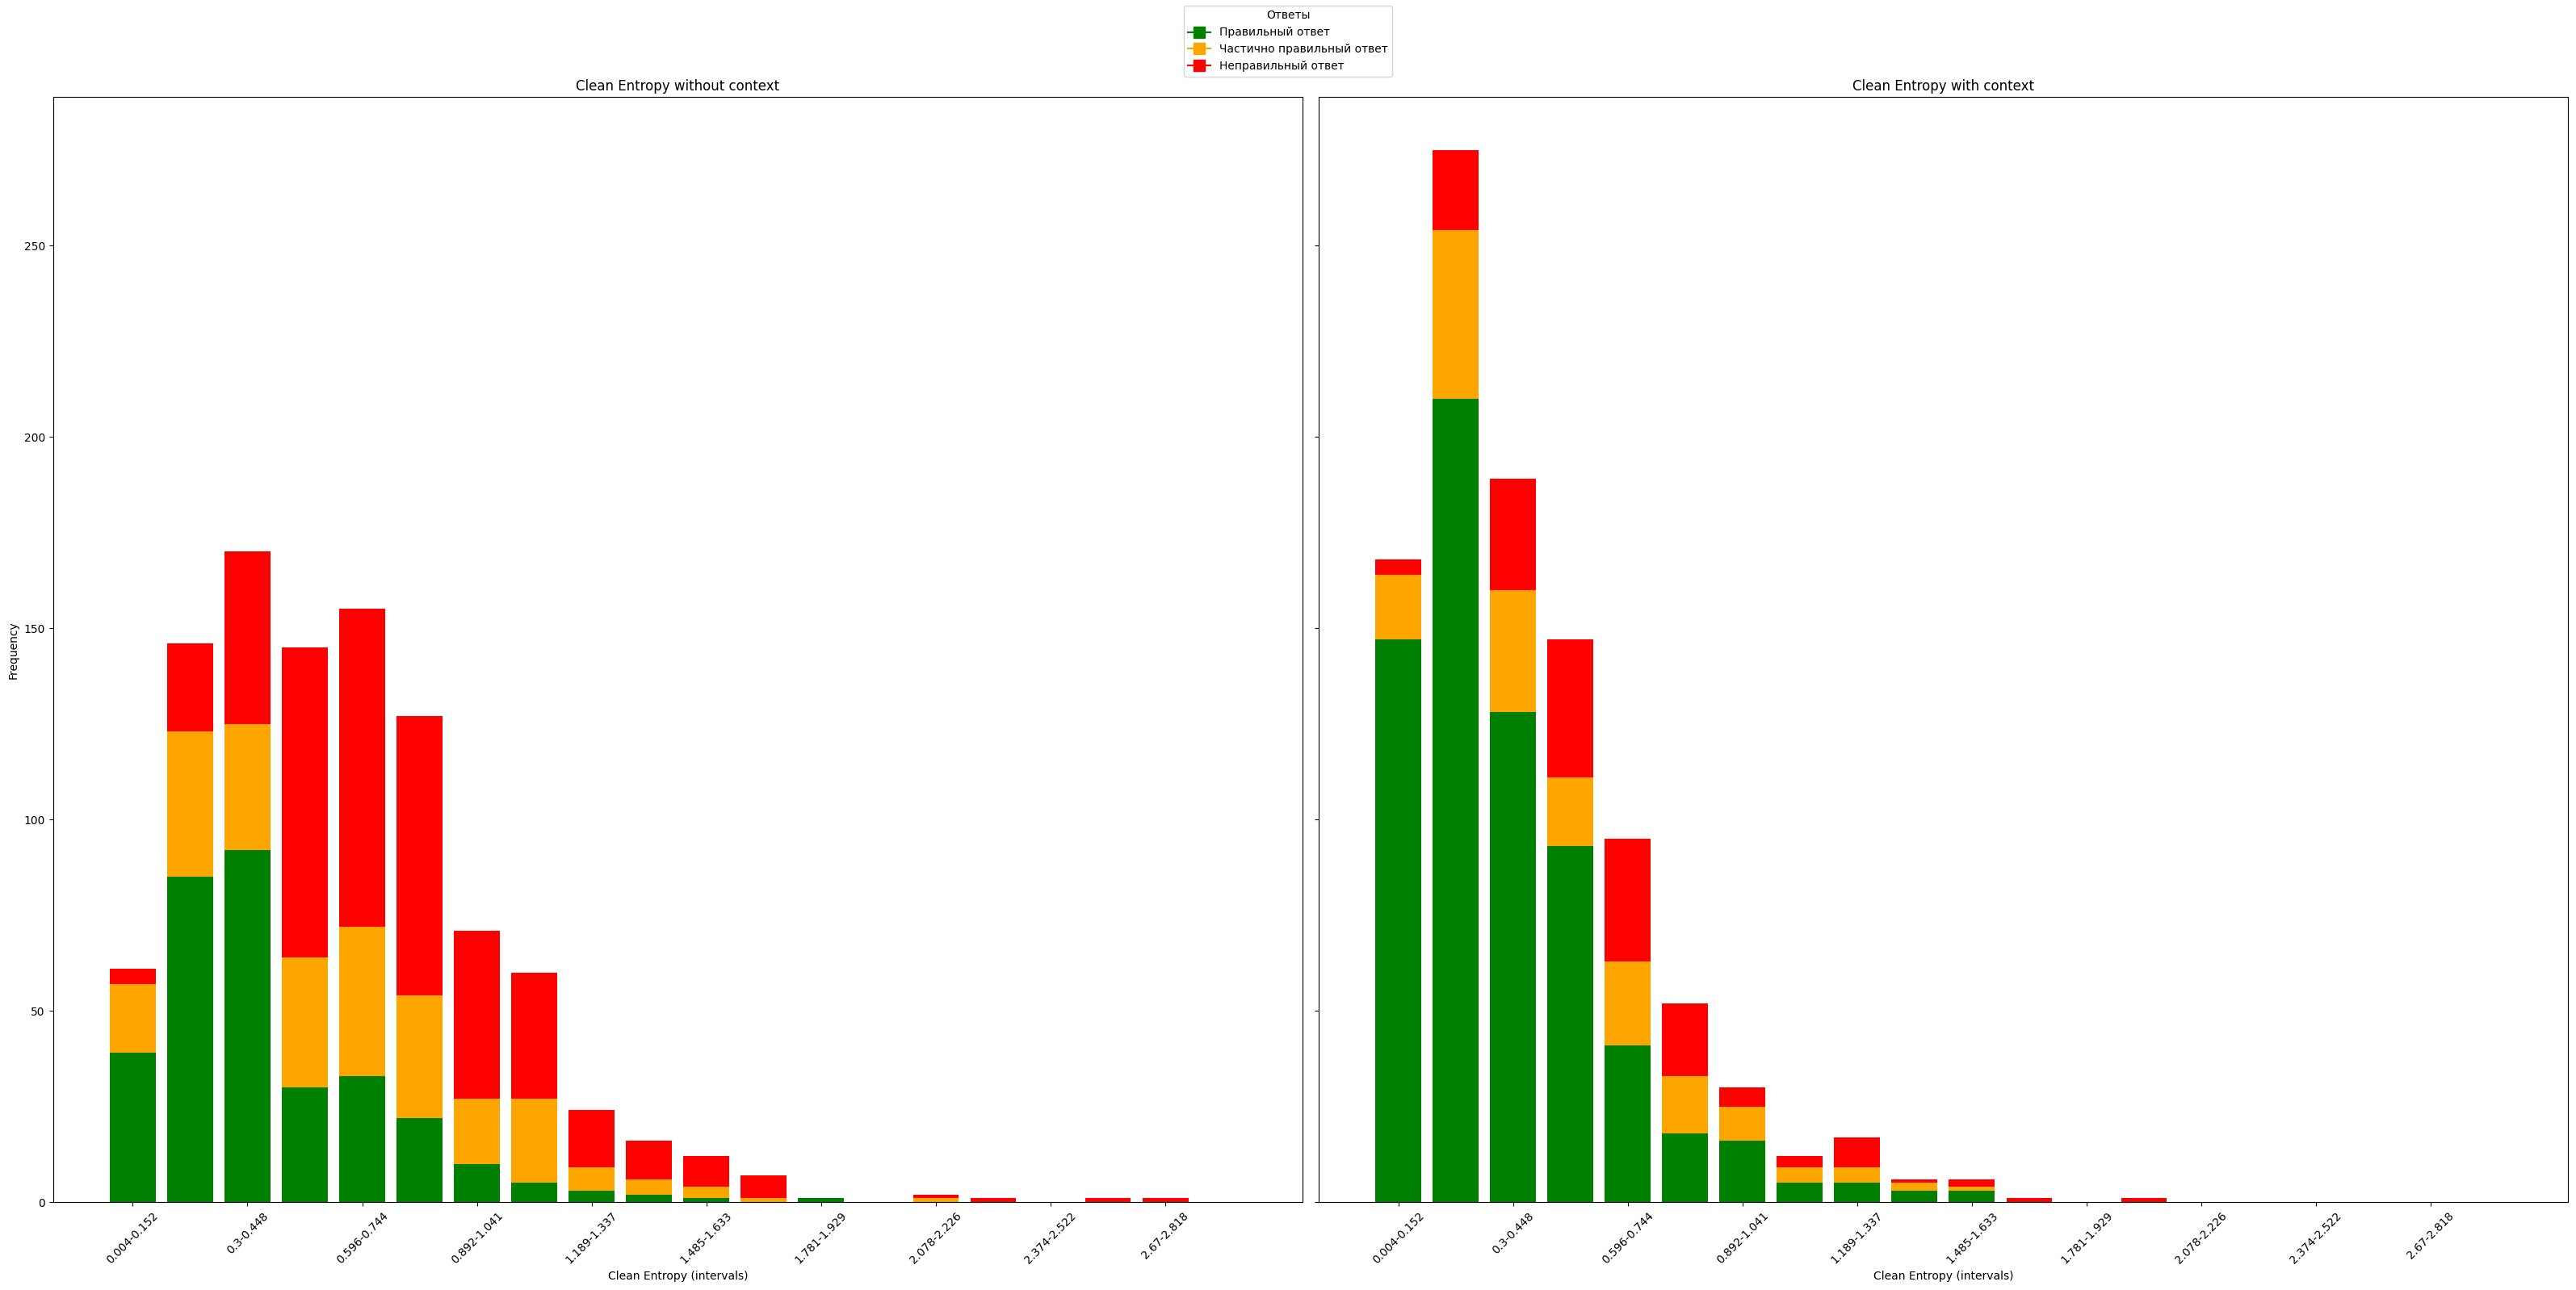

In [22]:
clean_entropy_min = min(nq_dataset['clean_entropy_without_context'].min(), nq_dataset['clean_entropy_with_context'].min())
clean_entropy_max = max(nq_dataset['clean_entropy_without_context'].max(), nq_dataset['clean_entropy_with_context'].max())
bin_edges = np.linspace(clean_entropy_min, clean_entropy_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'correct': 0,
    'partially_correct': 0,
    'incorrect': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask = (nq_dataset['clean_entropy_without_context'] >= bin_edges[i]) & (nq_dataset['clean_entropy_without_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 1).values)
    binned_data_without_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0.5).values)
    binned_data_without_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0).values)

for i in range(num_bins):
    bin_mask = (nq_dataset['clean_entropy_with_context'] >= bin_edges[i]) & (nq_dataset['clean_entropy_with_context'] < bin_edges[i + 1])
    binned_data_with_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 1).values)
    binned_data_with_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0.5).values)
    binned_data_with_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0).values)

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['correct'], color='green', label='Правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['partially_correct'], bottom=binned_data_without_context['correct'], color='orange', label='Частично правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['incorrect'], bottom=binned_data_without_context['correct'] + binned_data_without_context['partially_correct'], color='red', label='Неправильный ответ')
ax1.set_xlabel('Clean Entropy (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Clean Entropy without context')
ax1.set_xticks(np.arange(0, len(x_labels_without_context), max(1, len(x_labels_without_context) // 10)))
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['correct'], color='green', label='Правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['partially_correct'], bottom=binned_data_with_context['correct'], color='orange', label='Частично правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['incorrect'], bottom=binned_data_with_context['correct'] + binned_data_with_context['partially_correct'], color='red', label='Неправильный ответ')
ax2.set_xlabel('Clean Entropy (intervals)')
ax2.set_title('Clean Entropy with context')
ax2.set_xticks(np.arange(0, len(x_labels_with_context), max(1, len(x_labels_with_context) // 10)))
ax2.tick_params(axis='x', rotation=45)

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [
    plt.Line2D([0], [0], marker='s', color='green', markersize=10, label='Правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='orange', markersize=10, label='Частично правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='red', markersize=10, label='Неправильный ответ')
]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

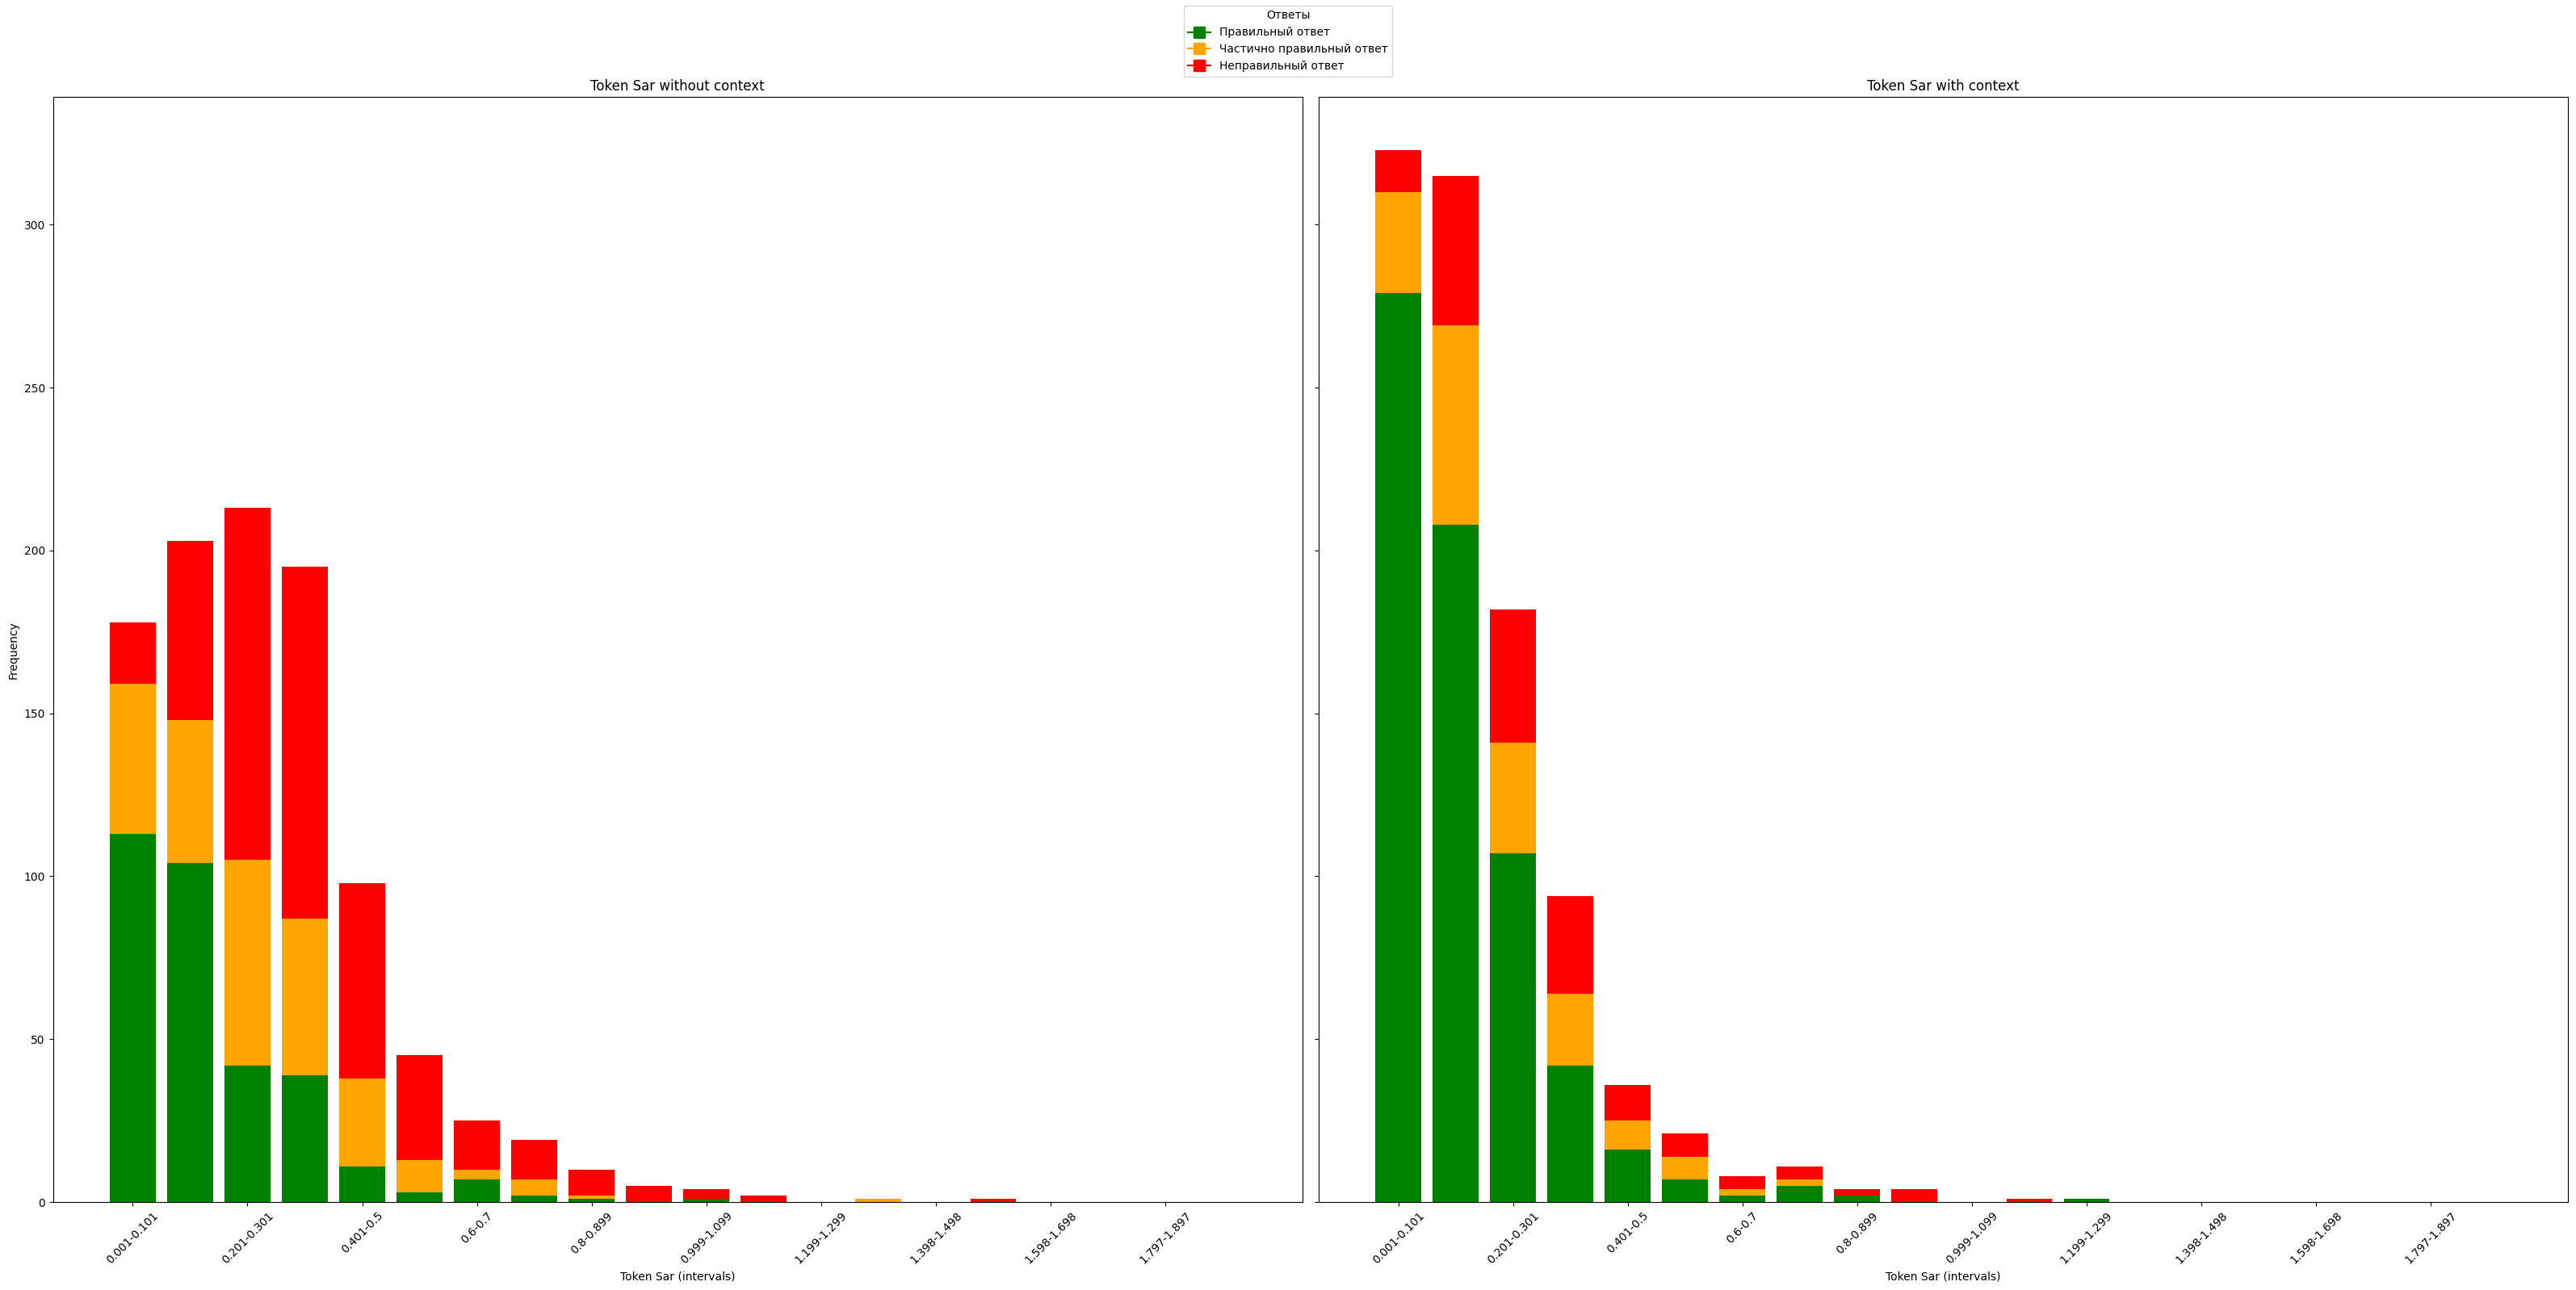

In [24]:
token_sar_min = min(nq_dataset['token_sar_without_context'].min(), nq_dataset['token_sar_with_context'].min())
token_sar_max = max(nq_dataset['token_sar_without_context'].max(), nq_dataset['token_sar_with_context'].max())
bin_edges = np.linspace(token_sar_min, token_sar_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'correct': 0,
    'partially_correct': 0,
    'incorrect': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask = (nq_dataset['token_sar_without_context'] >= bin_edges[i]) & (nq_dataset['token_sar_without_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 1).values)
    binned_data_without_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0.5).values)
    binned_data_without_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_without_context'] == 0).values)

for i in range(num_bins):
    bin_mask = (nq_dataset['token_sar_with_context'] >= bin_edges[i]) & (nq_dataset['token_sar_with_context'] < bin_edges[i + 1])
    binned_data_with_context.loc[i, 'correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 1).values)
    binned_data_with_context.loc[i, 'partially_correct'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0.5).values)
    binned_data_with_context.loc[i, 'incorrect'] = np.sum((nq_dataset[bin_mask]['chatgpt_is_correct_with_context'] == 0).values)

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['correct'], color='green', label='Правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['partially_correct'], bottom=binned_data_without_context['correct'], color='orange', label='Частично правильный ответ')
ax1.bar(x_labels_without_context, binned_data_without_context['incorrect'], bottom=binned_data_without_context['correct'] + binned_data_without_context['partially_correct'], color='red', label='Неправильный ответ')
ax1.set_xlabel('Token Sar (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Token Sar without context')
ax1.set_xticks(np.arange(0, len(x_labels_without_context), max(1, len(x_labels_without_context) // 10)))
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['correct'], color='green', label='Правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['partially_correct'], bottom=binned_data_with_context['correct'], color='orange', label='Частично правильный ответ')
ax2.bar(x_labels_with_context, binned_data_with_context['incorrect'], bottom=binned_data_with_context['correct'] + binned_data_with_context['partially_correct'], color='red', label='Неправильный ответ')
ax2.set_xlabel('Token Sar (intervals)')
ax2.set_title('Token Sar with context')
ax2.set_xticks(np.arange(0, len(x_labels_with_context), max(1, len(x_labels_with_context) // 10)))
ax2.tick_params(axis='x', rotation=45)

legend_labels = {1: 'Правильный ответ', 0.5: 'Частично правильный ответ', 0: 'Неправильный ответ'}
legend_entries = [
    plt.Line2D([0], [0], marker='s', color='green', markersize=10, label='Правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='orange', markersize=10, label='Частично правильный ответ'),
    plt.Line2D([0], [0], marker='s', color='red', markersize=10, label='Неправильный ответ')
]
fig.legend(handles=legend_entries, title="Ответы", loc='upper center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Add marked up is_lack_of_info by ChatGPT

In [ ]:
system_prompt = "As a response evaluator, output 1 when the model’s response indicates uncertainty, lacks information, or states an inability to provide information (e.g., ‘I don’t know,’ ‘I’m not sure,’ or ‘I cannot provide any information on this topic’). Output 0 if the model’s response contains relevant information, explanations, or attempts to provide a clear and informative answer to the prompt."

for index, row in tqdm(nq_dataset.iterrows()):
    answer_without_context = row['our_answer_without_context']
    answer_with_context = row["our_answer_with_context"]

    is_lack_of_info_without_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": answer_without_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    is_lack_of_info_with_context = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": answer_with_context},
            {"role": "system", "content": system_prompt}
        ]
    ).choices[0].message.content

    nq_dataset.loc[index, f'is_lack_of_info_without_context'] = is_lack_of_info_without_context
    nq_dataset.loc[index, f'is_lack_of_info_with_context'] = is_lack_of_info_with_context

## UE of squad 2

In [6]:
squad_2 = pd.read_csv('data/squad2/impossible_questions_with_unique_contexts.csv').sample(1000, random_state=42)

for index, row in tqdm(squad_2.iterrows(), total=len(squad_2)):
    question = row['question']
    context = row['context']

    # entropy without context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=question,
        clean_tokens_in_output=False
    )
    answer_without_context, entropy_without_context = result.generation_text, result.uncertainty

    # entropy with context
    result = estimate_uncertainty(
        model, 
        MeanTokenEntropy_method, 
        input_text=transfer_context_prompt(question, context),
        clean_tokens_in_output=False
    )
    
    answer_with_context, entropy_with_context = result.generation_text, result.uncertainty

    squad_2.loc[index, f'our_answer_without_context'] = answer_without_context
    squad_2.loc[index, f'our_answer_with_context'] = answer_with_context

    squad_2.loc[index, 'entropy_without_context'] = round(entropy_without_context, 4)
    squad_2.loc[index, 'entropy_with_context'] = round(entropy_with_context, 4)

squad_2.to_csv('data/ue_impossible_questions_with_unique_contexts.csv', index=False)

100%|██████████| 1000/1000 [1:08:08<00:00,  4.09s/it]


In [3]:
squad_2 = pd.read_csv('data/ue_impossible_questions_with_unique_contexts.csv')

In [5]:
squad_2.head()

,question,context,our_answer_without_context,our_answer_with_context,entropy_without_context,entropy_with_context
0,What allows extensive vegitation to occur?,The climate of Antarctica does not allow exten...,Several factors allow extensive vegetation to ...,Freezing temperatures.,0.6790,0.8166
1,"How has ""Process and Reality"" been rejected?",Wieman's words proved prophetic. Though Proces...,I'm not aware of any specific information abou...,"There is no information provided about how ""Pr...",1.0631,0.7767
2,What came into use in the 1800's?,The term prime minister in the sense that we k...,Here are some notable inventions and innovatio...,The telephone.,0.5945,2.1131
3,What board refused to see Sanskrit as an alter...,The CBSE (Central Board of Secondary Education...,I couldn't find any information on a specific ...,The CBSE (Central Board of Secondary Education),0.4038,0.9137
4,Where did Anne Catherine Emmerich live?,"In the 19th century, a house near Ephesus in T...","I couldn't find any information on an ""Anne Ca...",Anne Catherine Emmerich,0.4768,0.5385


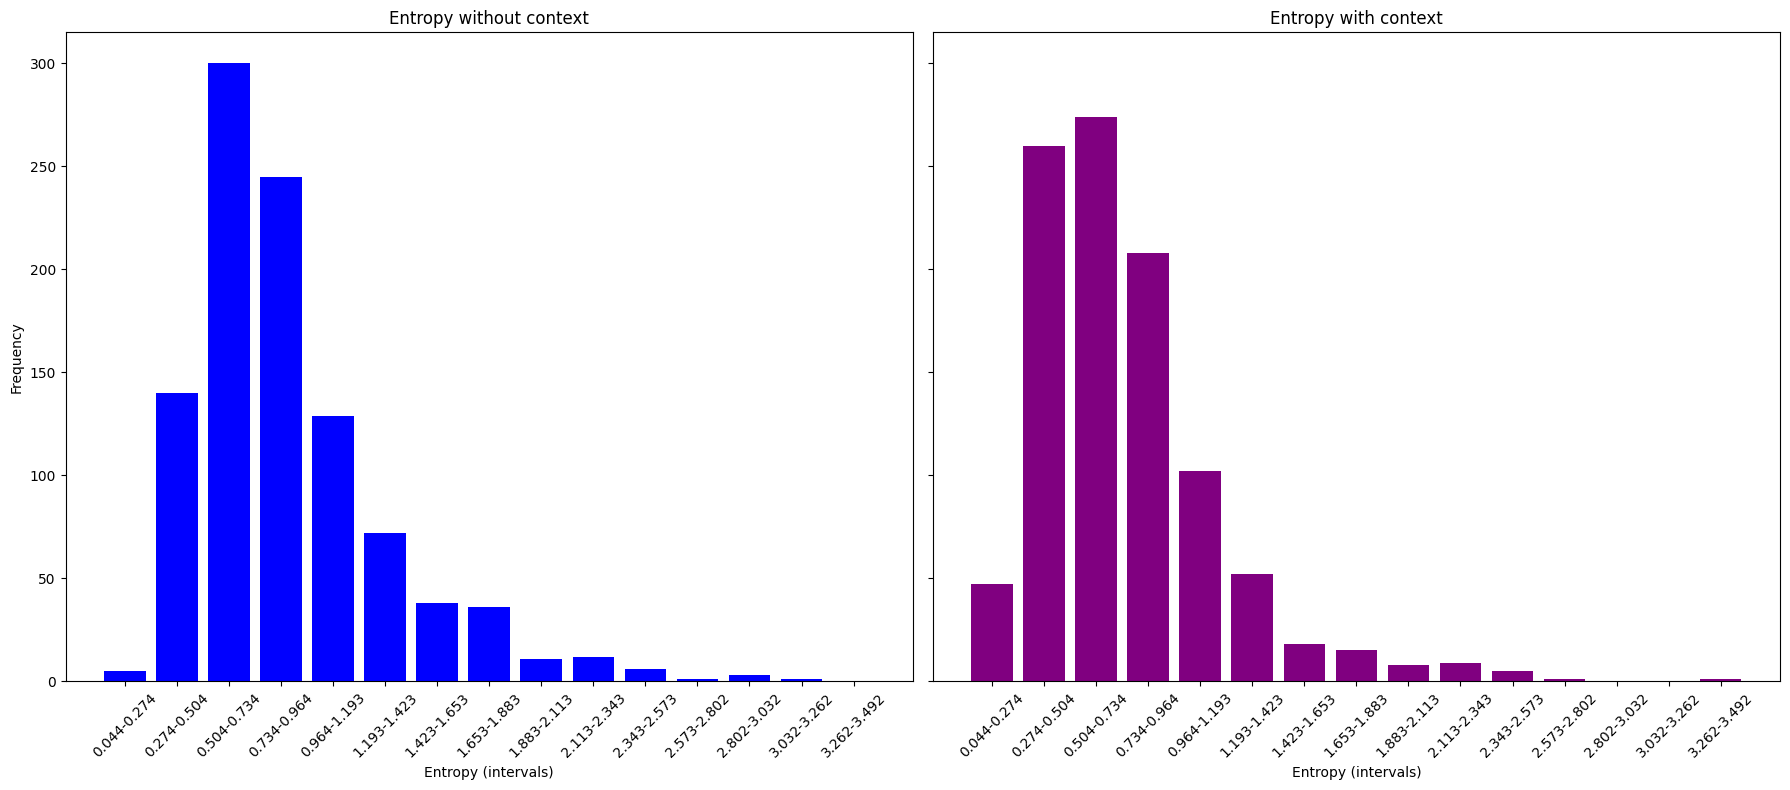

In [10]:
num_bins = 15

entropy_min = min(squad_2['entropy_without_context'].min(), squad_2['entropy_with_context'].min())
entropy_max = max(squad_2['entropy_without_context'].max(), squad_2['entropy_with_context'].max())
bin_edges = np.linspace(entropy_min, entropy_max, num_bins + 1)

binned_data_without_context = pd.DataFrame({
    'bin_left': bin_edges[:-1],
    'bin_right': bin_edges[1:],
    'count': 0
})

binned_data_with_context = binned_data_without_context.copy()

for i in range(num_bins):
    bin_mask_without = (squad_2['entropy_without_context'] >= bin_edges[i]) & (squad_2['entropy_without_context'] < bin_edges[i + 1])
    bin_mask_with = (squad_2['entropy_with_context'] >= bin_edges[i]) & (squad_2['entropy_with_context'] < bin_edges[i + 1])
    binned_data_without_context.loc[i, 'count'] = bin_mask_without.sum()
    binned_data_with_context.loc[i, 'count'] = bin_mask_with.sum()

x_labels_without_context = binned_data_without_context['bin_left'].round(3).astype(str) + '-' + binned_data_without_context['bin_right'].round(3).astype(str)
x_labels_with_context = binned_data_with_context['bin_left'].round(3).astype(str) + '-' + binned_data_with_context['bin_right'].round(3).astype(str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

ax1.bar(x_labels_without_context, binned_data_without_context['count'], color='blue', label='Entropy without context')
ax1.set_xlabel('Entropy (intervals)')
ax1.set_ylabel('Frequency')
ax1.set_title('Entropy without context')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(x_labels_with_context, binned_data_with_context['count'], color='purple', label='Entropy with context')
ax2.set_xlabel('Entropy (intervals)')
ax2.set_title('Entropy with context')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()